# Explorig the effects of zeros in OscoNet


In [1]:
%matplotlib inline
from OscopeBootstrap import qvalue
from OscopeBootstrap.create_edge_network_represention import create_edge_network_representation
from OscopeBootstrap.SyntheticDataset import GetSimISyntheticData, true_adj_matrix
from OscopeBootstrap.oscope_tf import bootstrap_hypothesis_test, get_accuracy, get_metrics_for_different_qvalue_thresholds2, get_metrics_for_different_qvalue_thresholds
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple



In [2]:
def GetSimZeros(NG: int = 15, G: int = 1000, N: int = 100, noiseLevel: int = 0,a: float =0.05, ngroups: int = 3) \
        -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    sigma_strLevel = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    sigma_str = sigma_strLevel[noiseLevel]

    data = np.zeros((G, N))
    data[:] = np.nan
    # genes per weak/strong oscillatory group
    # Group 1
    cellName = []
    for i in range(N):
        cellName.append('C'+str(i))

    geneName = []

    phaseG = np.zeros((G))
    angularSpeed = np.zeros((G))
    #a=0.01#percentage of zeros desired. Setting for No zero inflation is a=0.05, l=0.1
    l=0.1
    nn=round(a*N)
    mm1=round((N-nn)/2)
    if  ((nn % 2) == 0):
        mm2=mm1
    else:
        mm2=mm1+1
    nz=round(NG/2)
    t1 = np.linspace(0, 2*np.pi, N)
    t2 = np.random.permutation(t1)


    for i in range(nz):  # strong oscillators with zeros
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) #+ sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
        j0=np.random.randint(N-1, size=nn)
        data[i,j0]=-1
        data[i,:]= data[i,:] + sigma_str*np.random.randn(N)
    for i in range(nz, NG):  # strong oscillators without zeros
        t1 = np.linspace(0, 2*np.pi, N)
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    for i in range(NG, NG+nz):  # weak oscillators with zeros
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) #+ 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
        j0=np.random.randint(N-1, size=nn)
        data[i,j0]=-1
        data[i,:]= data[i,:] + 2*sigma_str*np.random.randn(N)
    for i in range(NG+nz, 2*NG):  # weak oscillators without zeros
        t1 = np.linspace(0, 2*np.pi, N)
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    if(ngroups >= 2):
        # Group 2
        #t2=np.linspace(0, 2*np.pi, N)
        for i in range(2*NG, 2*NG+nz):  # strong oscillators with zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) 
            geneName.append('G2SO'+str(i))
            j0=np.random.randint(N-1, size=nn)
            data[i,j0]=-1
            data[i,:]= data[i,:] + sigma_str*np.random.randn(N)
        for i in range(2*NG+nz, 3*NG):  # strong oscillators without zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G2SO'+str(i))
        for i in range(3*NG, 3*NG+nz):  # weak oscillators with zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase)
            geneName.append('G2WO'+str(i))
            j0=np.random.randint(N-1, size=nn)
            data[i,j0]=-1
            data[i, :] = data[i, :] + 2*sigma_str*np.random.randn(N)
        for i in range(3*NG+nz, 4*NG):  # weak oscillators without zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G2WO'+str(i))
  # white noise genes
    for w in range(i+1, G):  # use i index from above where it stopped
        phaseG[w] = np.nan
        angularSpeed[w] = np.nan
        data[w, :] = np.max([3/2 * sigma_str, 1]) * np.random.randn(N)
        geneName.append('R'+str(w))
    assert np.all(~ np.isnan(data)), 'Entries with nans!'
    assert len(geneName) == G
    assert len(cellName) == N
    df = pd.DataFrame(data, index=geneName, columns=cellName)
    return df, phaseG, angularSpeed




### Create a synthetic dataset containing one group of co-oscillating genes and vary the percentage of zeros in the original data (this corresponds to the number of -1 in the sinusoidal data)

/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 26 secs
get_pvalues 0 secs
qvalues pi0=0.979, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.33


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.007, estimated proportion of null features 
got pi0 > 1 (1.007) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.33


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 26 secs
get_pvalues 0 secs
qvalues pi0=1.005, estimated proportion of null features 
got pi0 > 1 (1.005) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.35


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 26 secs
get_pvalues 0 secs
qvalues pi0=0.952, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.32


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 26 secs
get_pvalues 0 secs
qvalues pi0=0.942, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.99, False discovery rate 0.31


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 26 secs
get_pvalues 0 secs
qvalues pi0=0.969, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.98, False discovery rate 0.35


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.951, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.94, False discovery rate 0.34


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.980, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.91, False discovery rate 0.37


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.995, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.90, False discovery rate 0.35


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.966, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.92, False discovery rate 0.37


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.982, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.86, False discovery rate 0.34


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.949, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.85, False discovery rate 0.37


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.015, estimated proportion of null features 
got pi0 > 1 (1.015) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.65, False discovery rate 0.41


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.009, estimated proportion of null features 
got pi0 > 1 (1.009) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.64, False discovery rate 0.45


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.016, estimated proportion of null features 
got pi0 > 1 (1.016) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.61, False discovery rate 0.44


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.028, estimated proportion of null features 
got pi0 > 1 (1.028) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.59, False discovery rate 0.47


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.025, estimated proportion of null features 
got pi0 > 1 (1.025) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.58, False discovery rate 0.45


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.037, estimated proportion of null features 
got pi0 > 1 (1.037) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.57, False discovery rate 0.49


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=1.002, estimated proportion of null features 
got pi0 > 1 (1.002) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.57, False discovery rate 0.47


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 25 secs
get_pvalues 0 secs
qvalues pi0=0.995, estimated proportion of null features 
Ratio of correctly identified pairs 0.98
True positive rate 0.49, False discovery rate 0.48


<ipython-input-6-4a4e5cff6b06>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-6-4a4e5cff6b06>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))


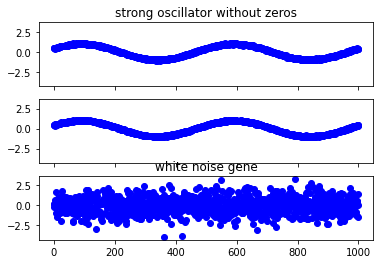

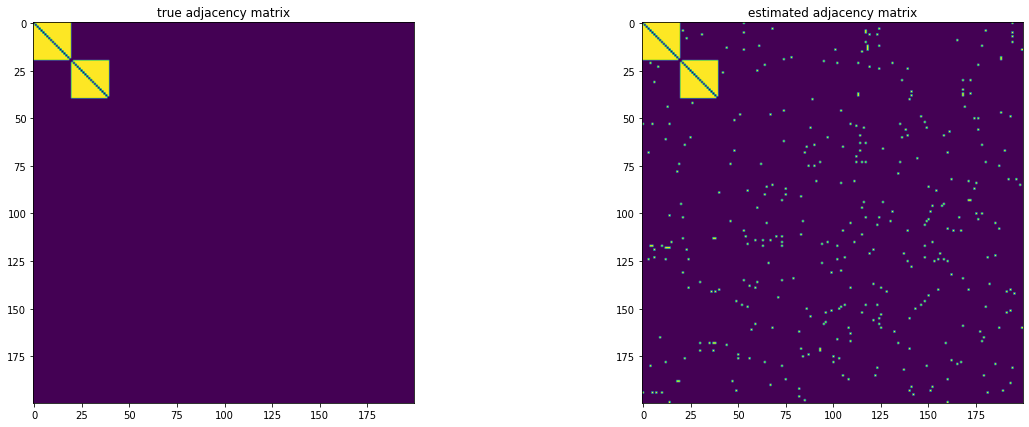

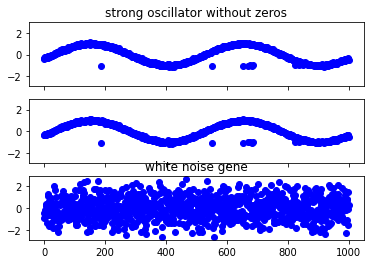

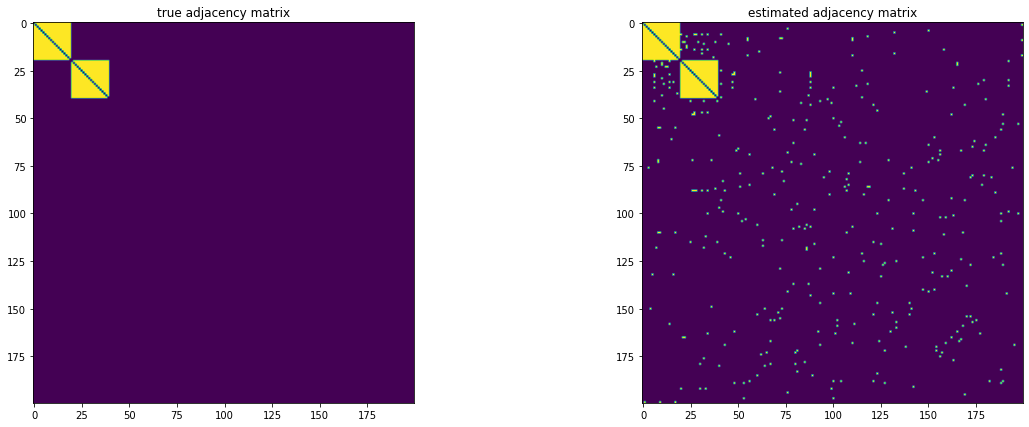

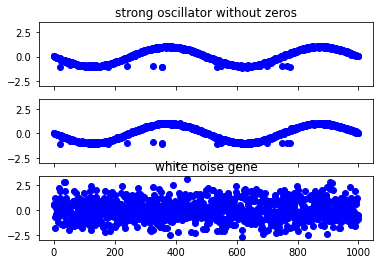

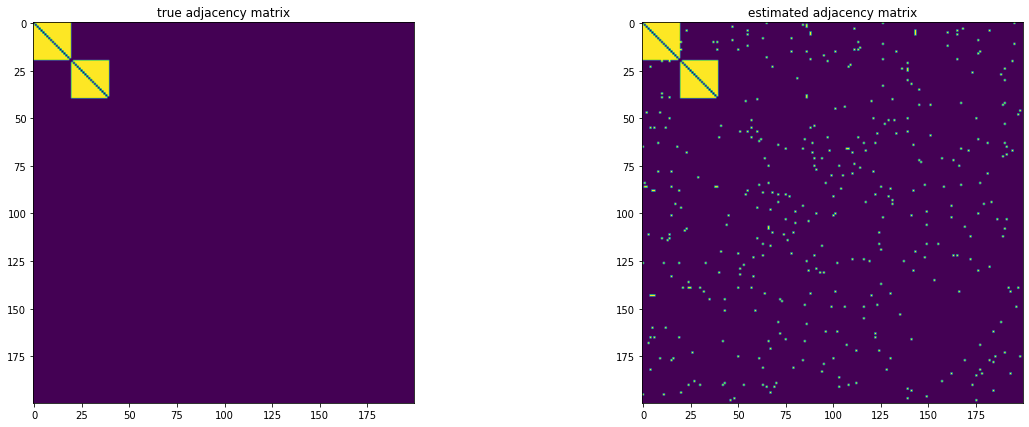

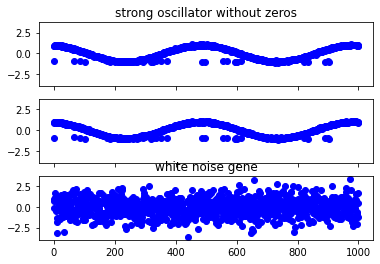

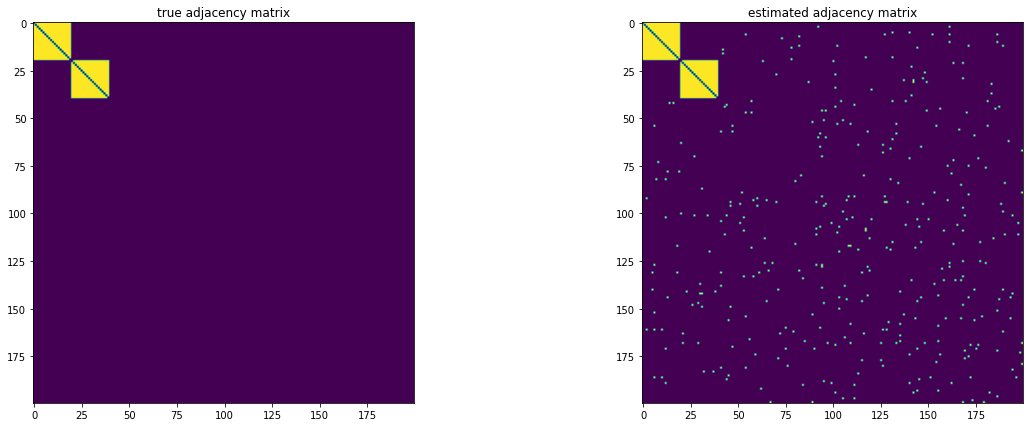

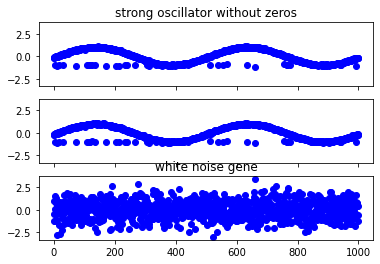

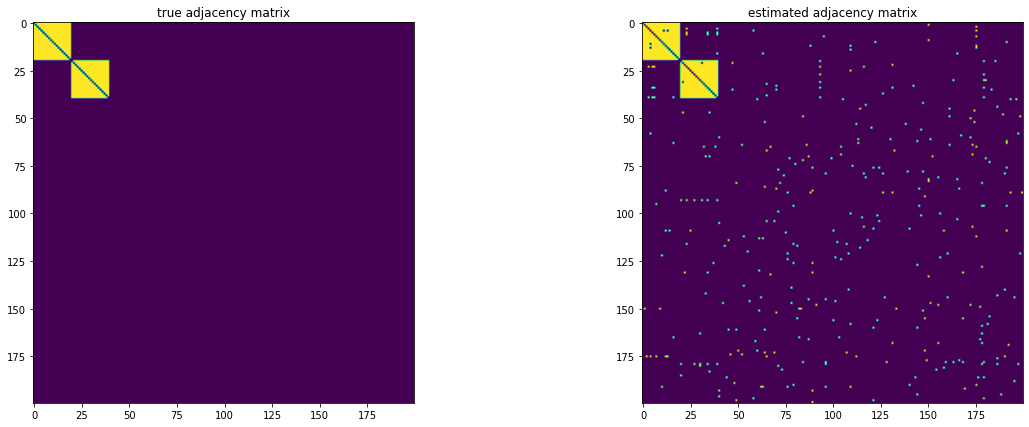

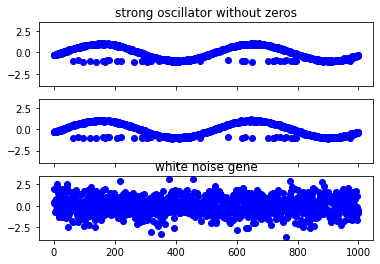

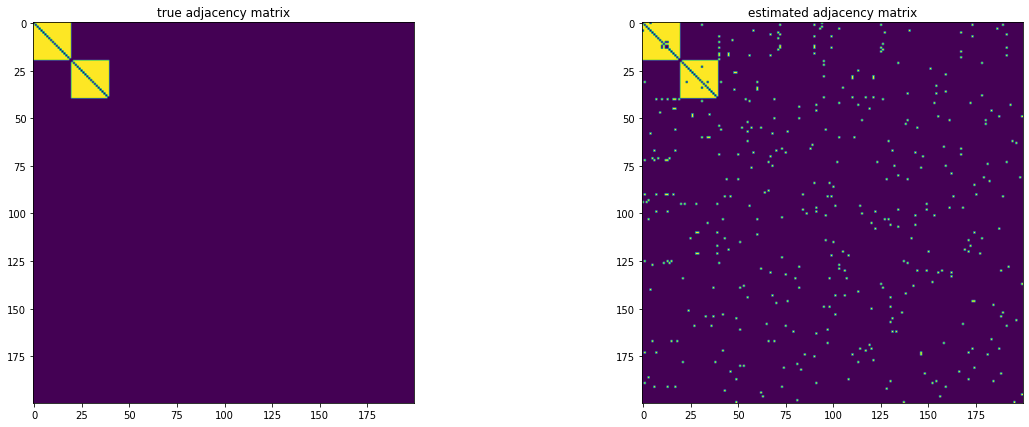

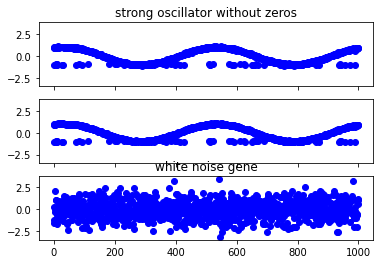

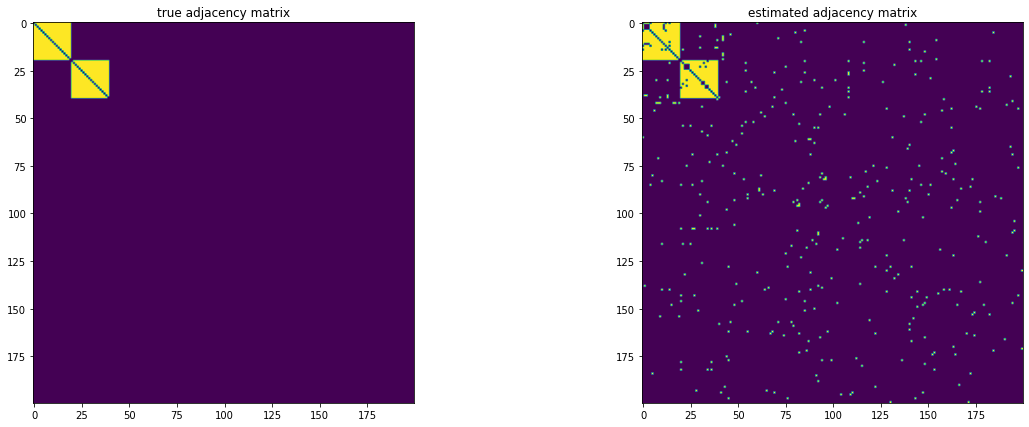

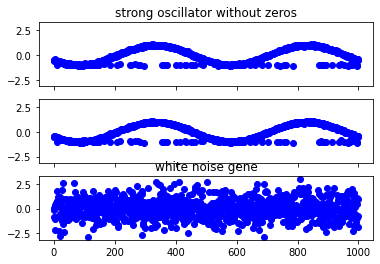

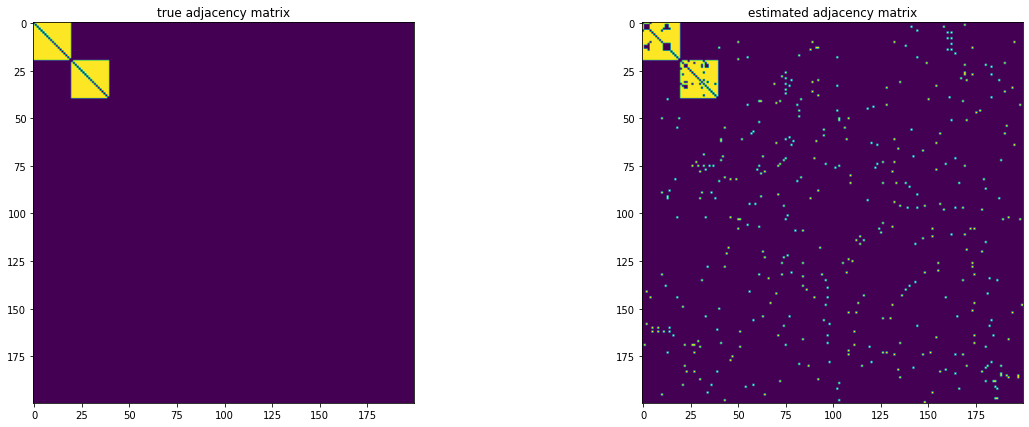

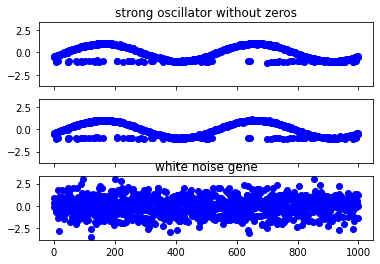

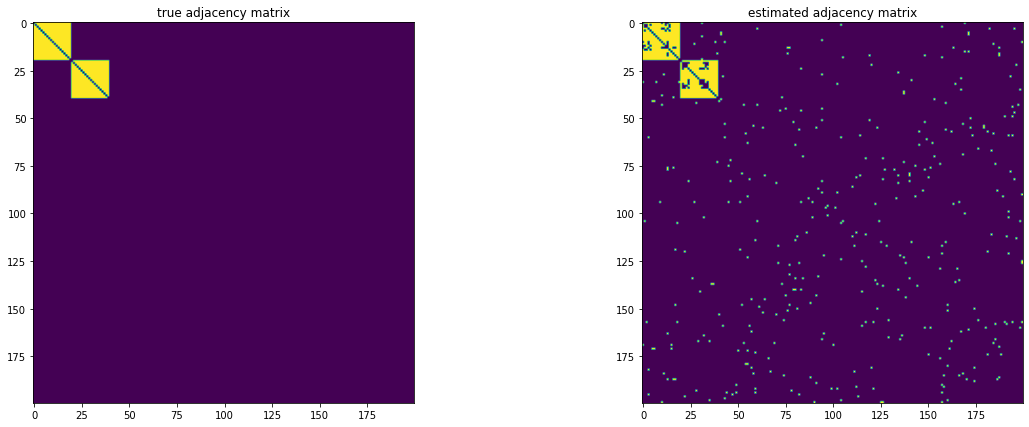

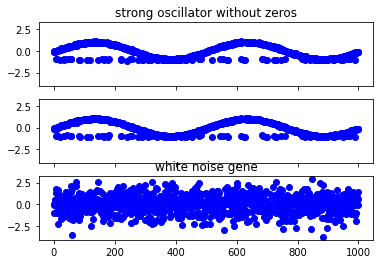

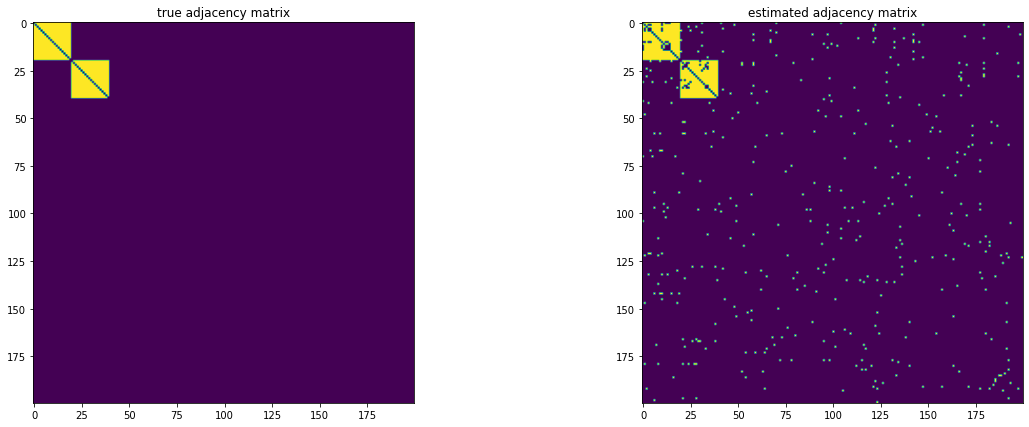

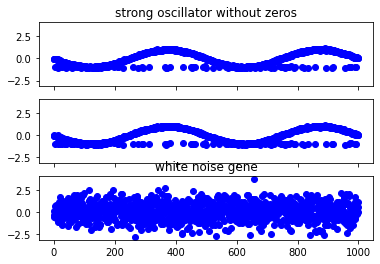

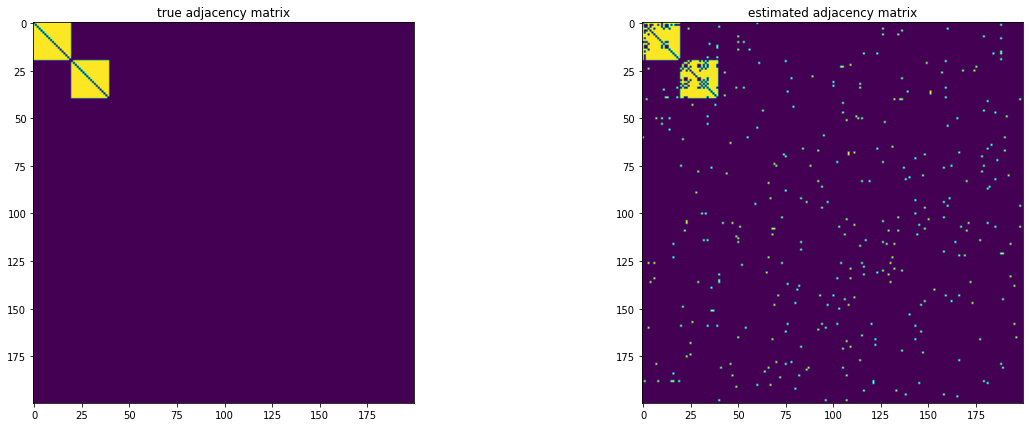

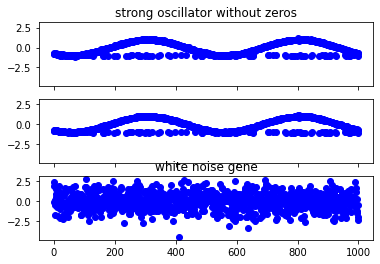

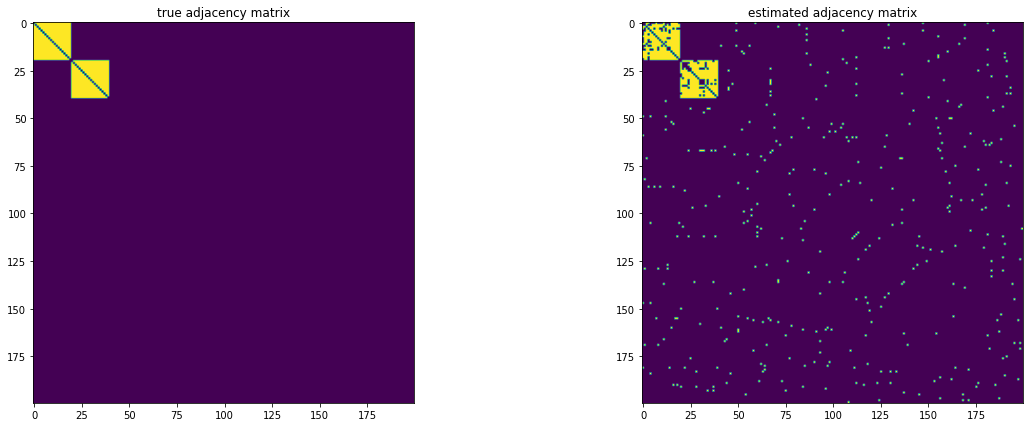

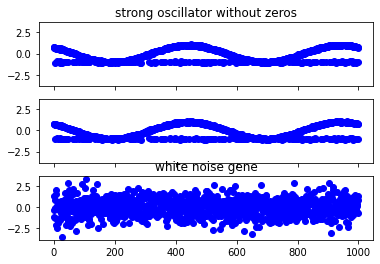

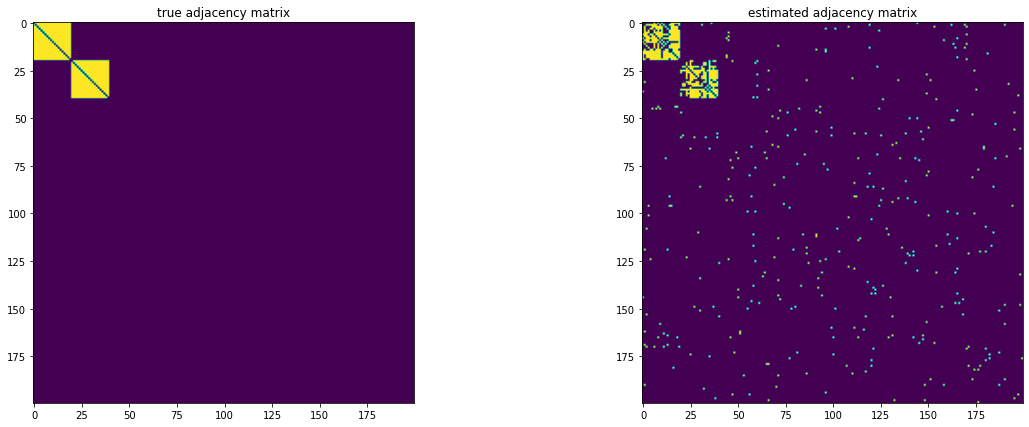

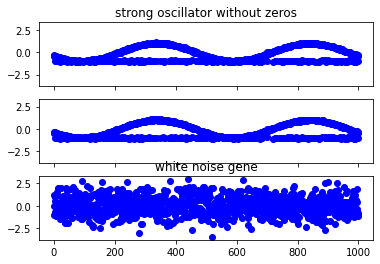

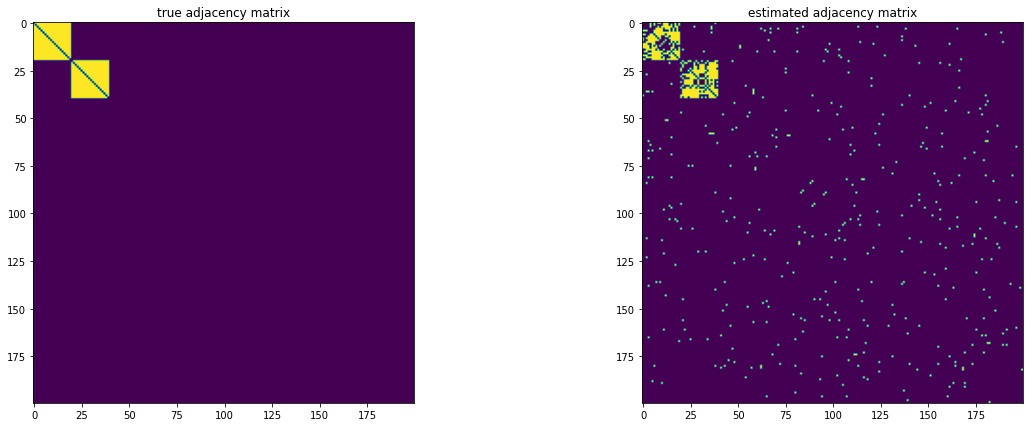

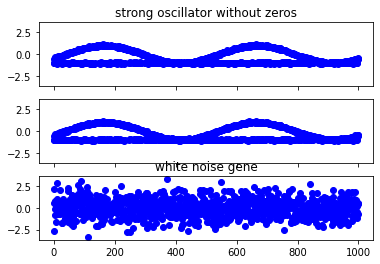

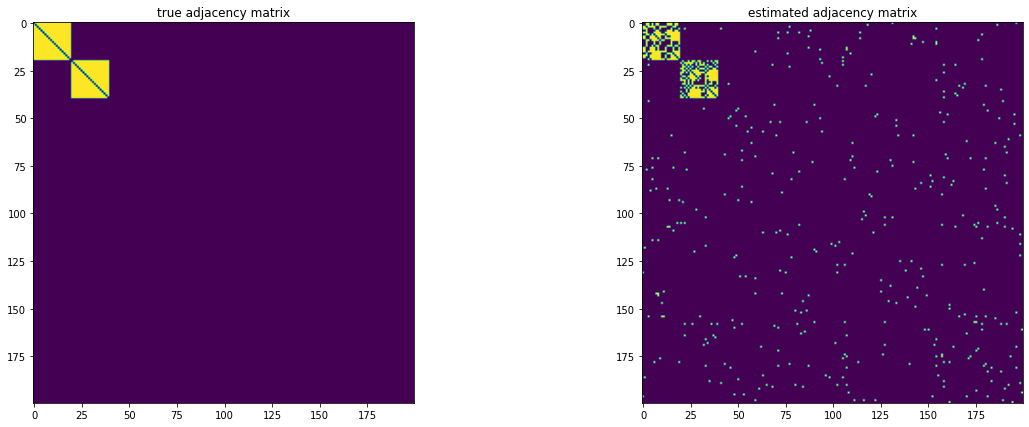

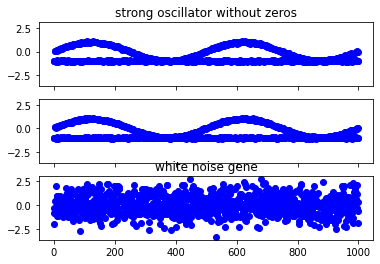

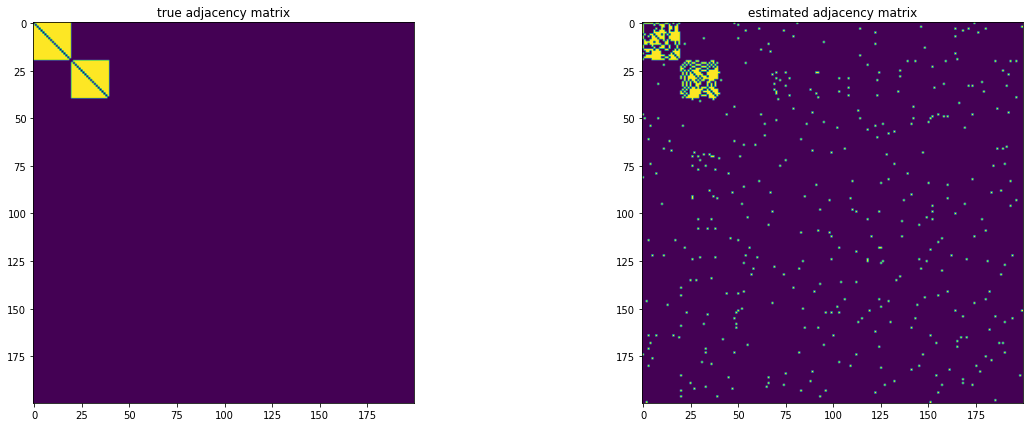

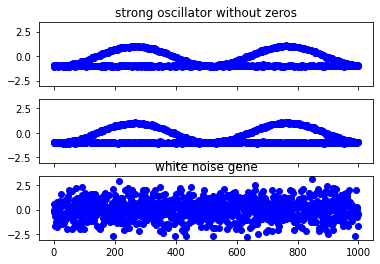

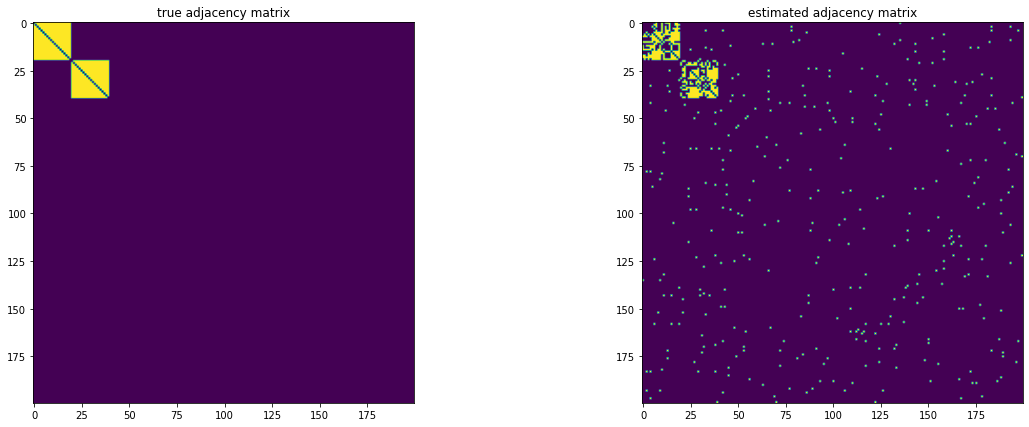

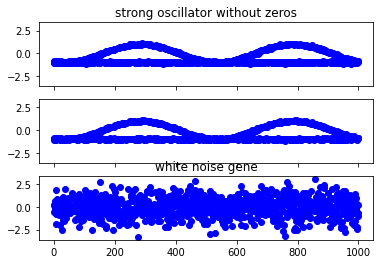

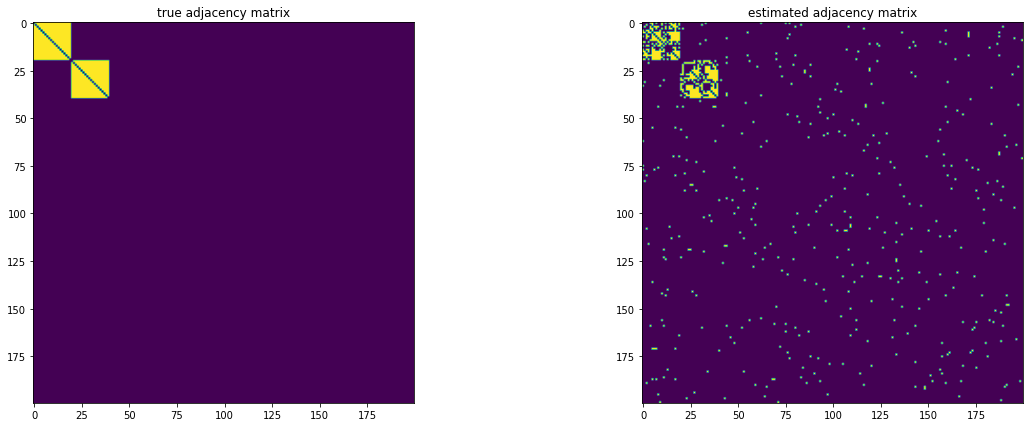

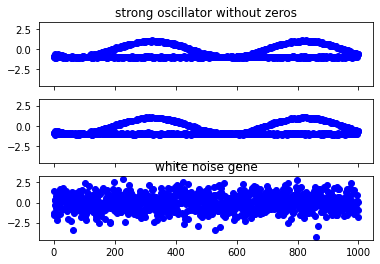

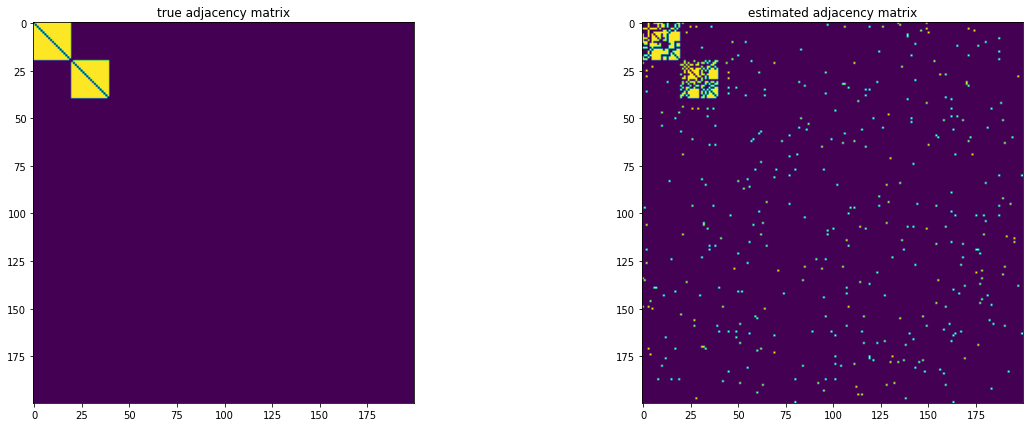

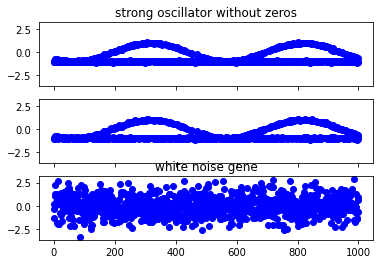

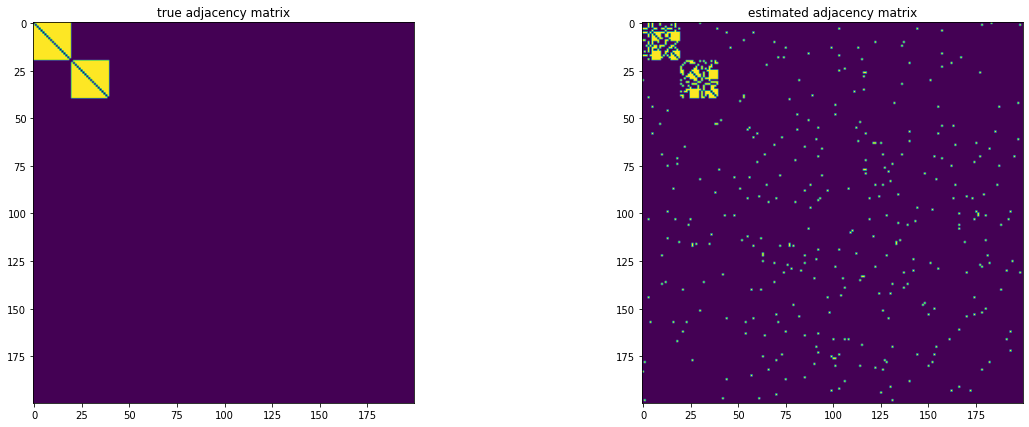

In [6]:
NG = 10  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 200  # number of genes
N = 1000 # cells
ngroups = 2 # num of cluster
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
a=[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.08,0.09,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
correct_ratio = np.zeros(len(a))
TPR = np.zeros(len(a))
FDR = np.zeros(len(a))
TP = np.zeros(len(a))
TN = np.zeros(len(a))
FP = np.zeros(len(a))
FN = np.zeros(len(a))
FPR = np.zeros(len(a))


for i in range(len(a)):
    data_df, phaseG, angularSpeed = GetSimZeros(NG=NG, G=G, N=N, noiseLevel=0,a=a[i], ngroups= ngroups)
    adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix
    adjacency_matrix, qvalues, cost_matrix, psi_matrix = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
    correct_ratio[i] = get_accuracy(adjacency_matrix, adjacency_matrix_true)
    print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
    TPR[i], FDR[i], FPR[i], TP[i], TN[i], FP[i], FN[i] = get_metrics_for_different_qvalue_thresholds2(qvalues, adjacency_matrix_true, np.array([alpha]))
    TPR[i], FDR[i], _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
    print(f'True positive rate {float(TPR[i]):.2f}, False discovery rate {float(FDR[i]):.2f}')
    _, ax = plt.subplots(3, sharex=True, sharey=True)
    ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator with zeros')
    ax[1].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator without zeros')
    ax[2].plot(np.arange(N), data_df.iloc[4*NG, :], 'bo'); ax[2].set_title('white noise gene')
    
    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
    ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

In [23]:
adjacency_matrix_true

array([[False,  True,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

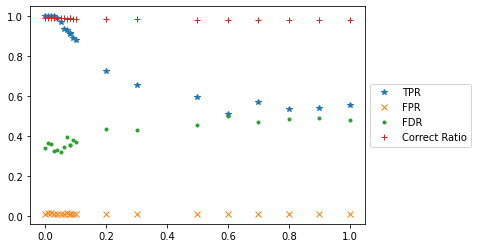

In [15]:
plt.plot(a,TPR,'*',label='TPR')
plt.plot(a,FPR,'x',label='FPR')

plt.plot(a,FDR,'.',label='FDR')
plt.plot(a,correct_ratio,'+',label='Correct Ratio');

legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
#
#plt.legend(loc='center left', frameon=True)


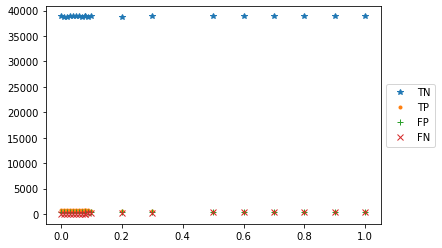

In [21]:
plt.plot(a,TN,'*',label='TN')
plt.plot(a,TP,'.',label='TP')
plt.plot(a,FP,'+',label='FP')
plt.plot(a,FN,'x',label='FN')

legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))


In [17]:
print('TPR=',TPR)
print('FDR=',FDR)
print('correct_ratio=',correct_ratio)

TPR= [1.         1.         1.         1.         0.99210526 0.97105263
 0.93684211 0.93157895 0.91052632 0.91842105 0.88947368 0.87894737
 0.72631579 0.65526316 0.59473684 0.51052632 0.57105263 0.53421053
 0.53947368 0.55526316]
FDR= [0.33913043 0.36454849 0.36134454 0.3250444  0.33156028 0.32044199
 0.34438306 0.39693356 0.35447761 0.35489834 0.37981651 0.37099812
 0.43558282 0.43020595 0.45542169 0.49870801 0.46943765 0.48607595
 0.49004975 0.47772277]
correct_ratio= [0.99020101 0.98904523 0.98919598 0.99080402 0.99045226 0.99070352
 0.98939698 0.98698492 0.98874372 0.98879397 0.98748744 0.98778894
 0.98407035 0.98396985 0.98276382 0.98095477 0.9821608  0.98145729
 0.98130653 0.98180905]


In [22]:
print('TP=',TP)
print('FP=',FP)
print('TN=',TN)
print('FN=',FN)
print('TP+FP=',TP+FP)
print('FN+TN=',FN+TN)

TP= [760. 760. 760. 760. 754. 738. 712. 708. 692. 698. 676. 668. 552. 498.
 452. 388. 434. 406. 410. 422.]
FP= [390. 436. 430. 366. 374. 348. 374. 466. 380. 384. 414. 394. 426. 376.
 378. 386. 384. 384. 394. 386.]
TN= [38850. 38804. 38810. 38874. 38866. 38892. 38866. 38774. 38860. 38856.
 38826. 38846. 38814. 38864. 38862. 38854. 38856. 38856. 38846. 38854.]
FN= [  0.   0.   0.   0.   6.  22.  48.  52.  68.  62.  84.  92. 208. 262.
 308. 372. 326. 354. 350. 338.]
TP+FP= [1150. 1196. 1190. 1126. 1128. 1086. 1086. 1174. 1072. 1082. 1090. 1062.
  978.  874.  830.  774.  818.  790.  804.  808.]
FN+TN= [38850. 38804. 38810. 38874. 38872. 38914. 38914. 38826. 38928. 38918.
 38910. 38938. 39022. 39126. 39170. 39226. 39182. 39210. 39196. 39192.]


In [662]:
# considering a -1,1 conversion the zeros (min) will go towars -1 . Consider [min,-0.985] as 0 range
#np.shape(np.where(x<-0.985))[1] #number of zeros if uniformly sampled in N=1000 cells are ~55 so ~5%
#we could increse the observations in [min,-0.985] to see the effects of zeros. This means that instead of:
#    t1 = np.linspace(0, 2*np.pi, N)
# we could use more dense sampling around 3/2*np.pi:
#a=0.001#percentage of zeros desired
#nn=round(a*N)
#t0 = np.linspace( 3/2*np.pi-0.2, 3/2*np.pi+0.2,nn)
#mm=round((1-a)*N/2)
#t1b0=np.linspace( 0, 3/2*np.pi-0.2,mm)
#t1a0=np.linspace( 3/2*np.pi+0.2,2*np.pi,mm)
#t1=np.concatenate((t1b0, t0,t1a0), axis=None)
#t1.shape

# Consider now only high percentage of zeros between 0 and 0.4

In [44]:
a

array([0.01879644, 0.02335595, 0.08297834, 0.09844622, 0.26595422,
       0.28702205, 0.31794262, 0.36343447, 0.42402462, 0.42611653])

find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.364, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.455, estimated proportion of null features 
Ratio of correctly identified pairs 0.97
True positive rate 0.89, False discovery rate 0.00
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.818, estimated proportion of null features 
Ratio of correctly identified pairs 0.95
True positive rate 0.84, False discovery rate 0.01
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.000, estimated proportion of null features 
got pi0 > 1 (1.000) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.92
True positive rate 0.73, False discovery rate 0.01
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.273, estimated proportion of null features 
got pi0 > 1 (1.273) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.92
True positive rate 0.76, False discovery rate 0.03
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.091, estimated proportion of null features 
got pi0 > 1 (1.091) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.88
True positive rate 0.69, False discovery rate 0.10


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.212, estimated proportion of null features 
got pi0 > 1 (1.212) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.87
True positive rate 0.63, False discovery rate 0.08
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.394, estimated proportion of null features 
got pi0 > 1 (1.394) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.87
True positive rate 0.57, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.121, estimated proportion of null features 
got pi0 > 1 (1.121) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.91
True positive rate 0.71, False discovery rate 0.03


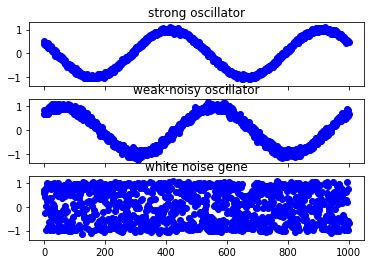

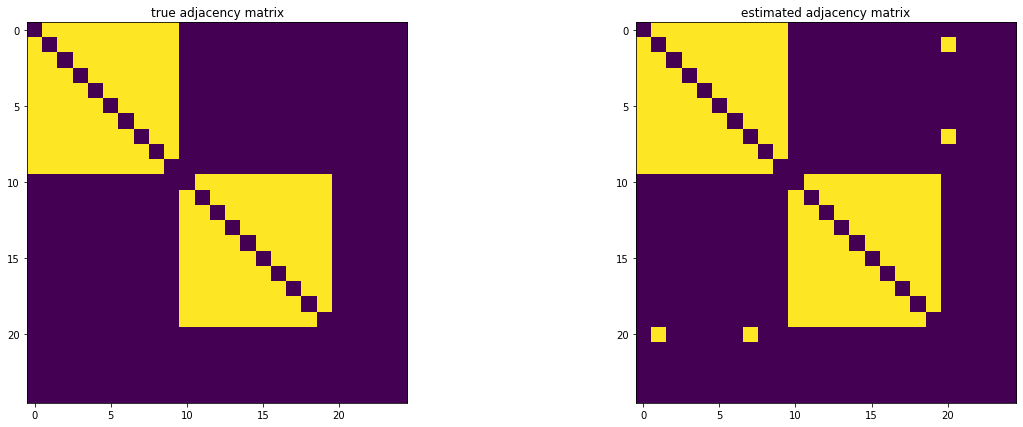

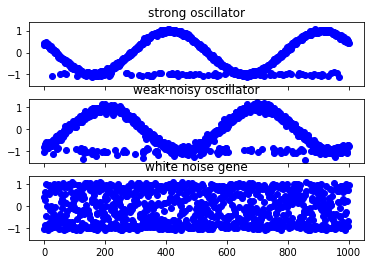

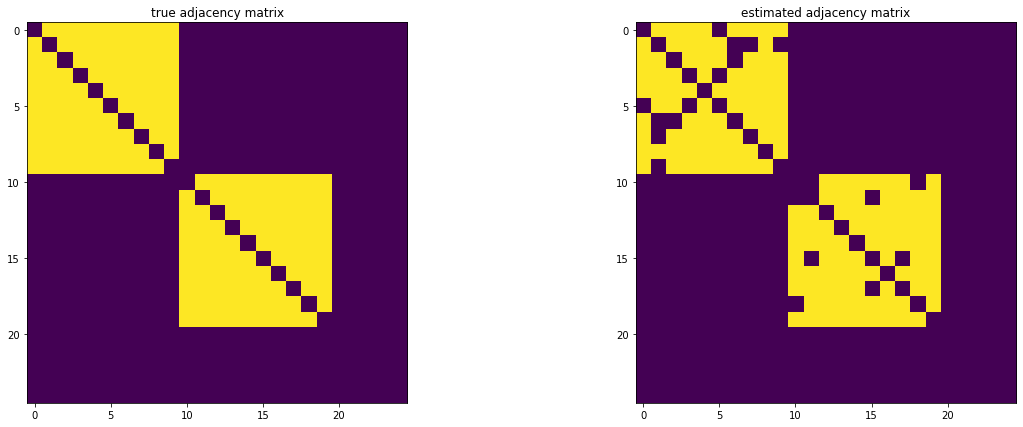

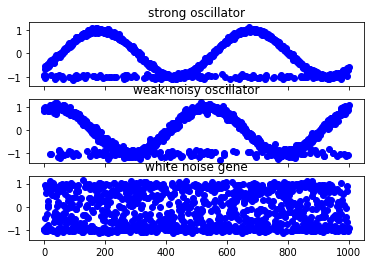

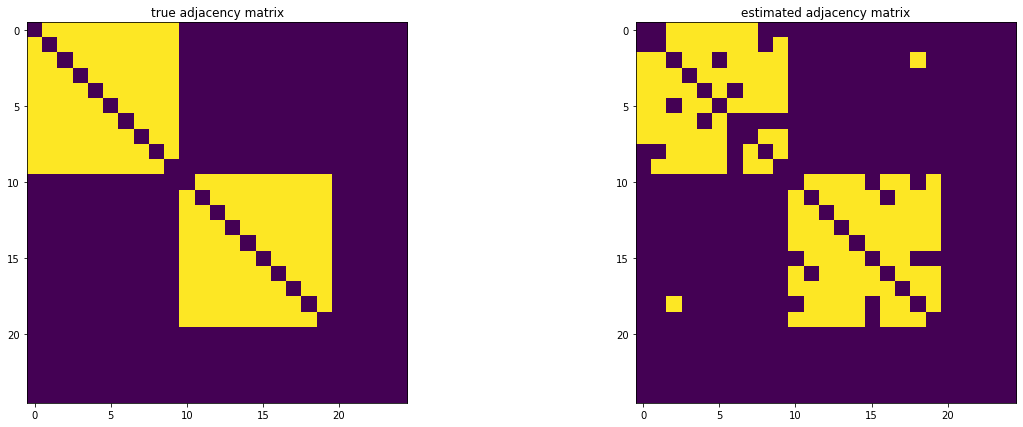

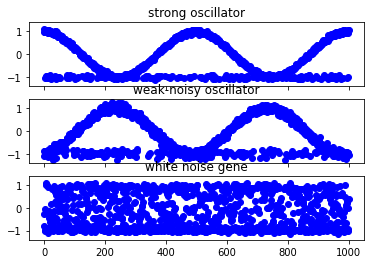

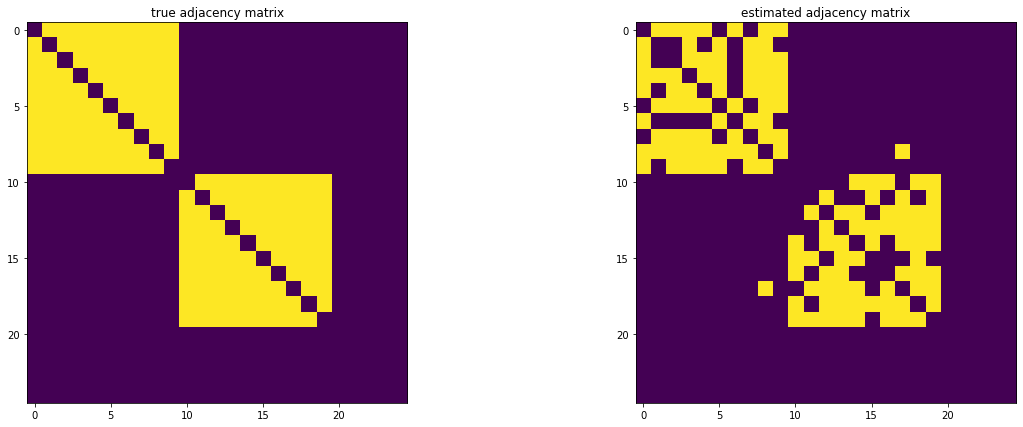

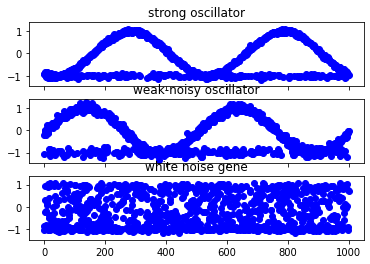

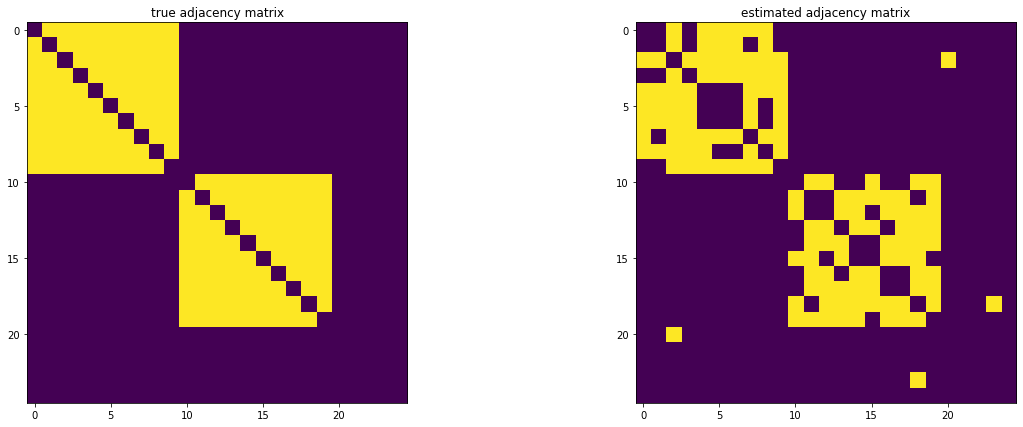

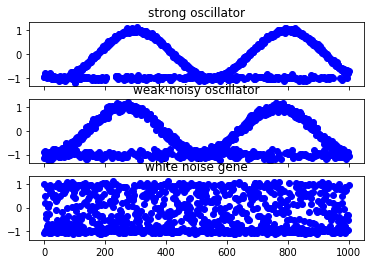

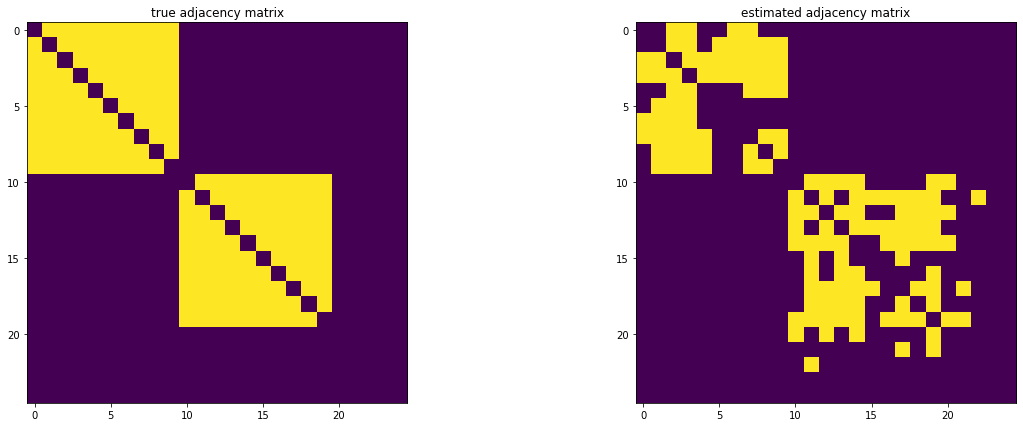

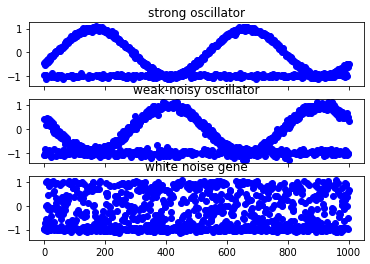

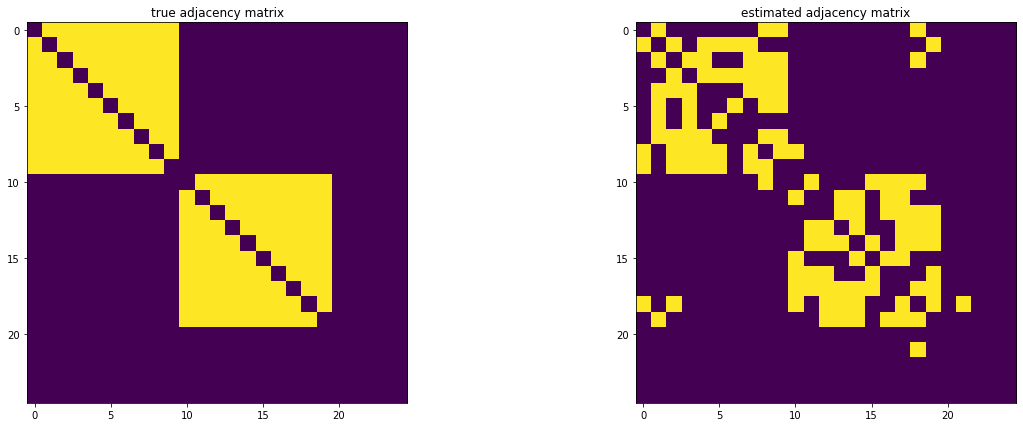

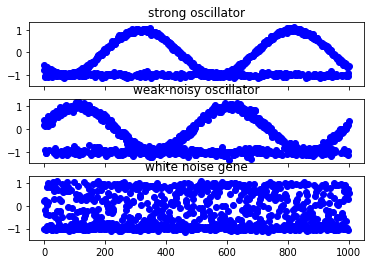

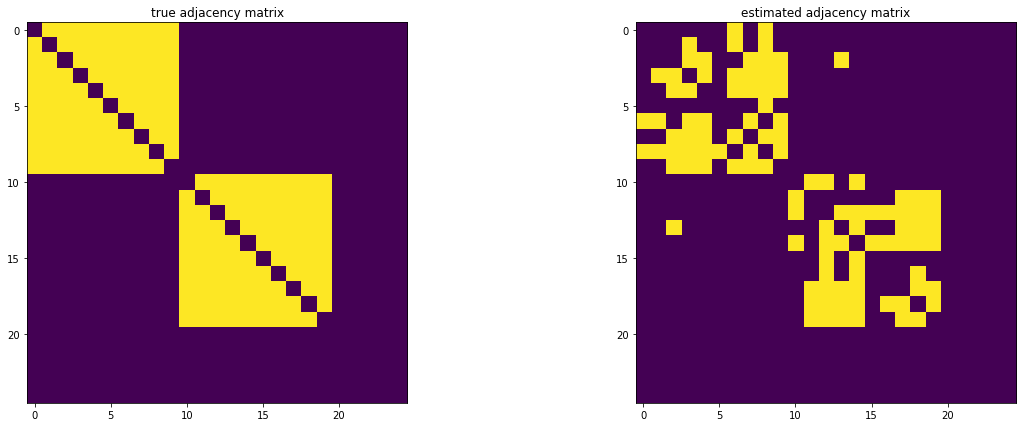

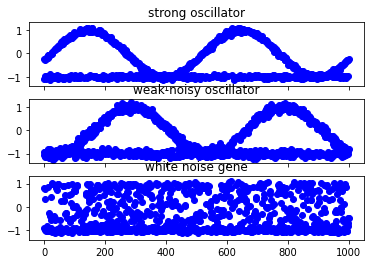

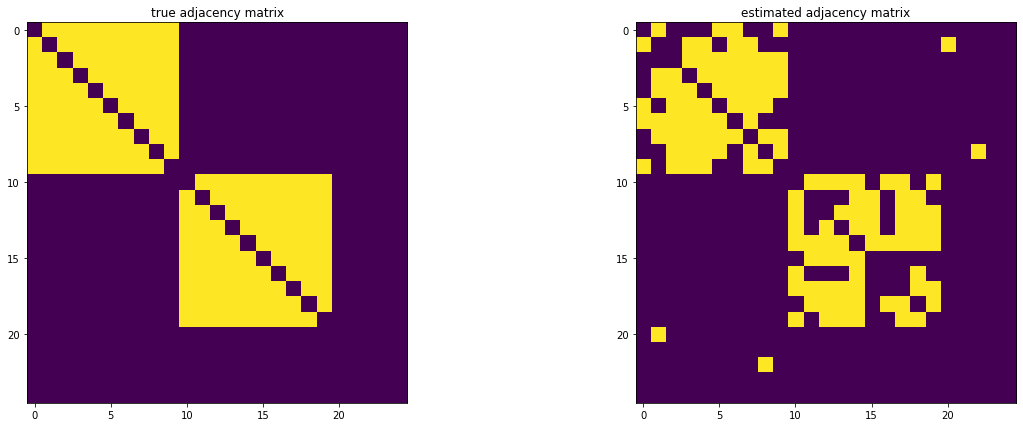

In [5]:
NG = 5  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 25 
N = 1000 # cells
ngroups = 2 # one cluster
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
#a=np.random.uniform(0,0.45,10)
#a=np.sort(a)  
a=[0,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]
correct_ratio = np.zeros(len(a))
TPR = np.zeros(len(a))
FDR = np.zeros(len(a))

for i in range(len(a)):
    data_df, phaseG, angularSpeed = GetSimZeros(NG=NG, G=G, N=N, noiseLevel=0,a=a[i])
    adjacency_matrix, qvalues, cost_matrix, psi_matrix = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
    adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix

    correct_ratio[i] = get_accuracy(adjacency_matrix, adjacency_matrix_true)
    print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
    TPR[i], FDR[i], _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
    TPR[i], FDR[i], FPR[i], TP[i], TN[i], FP[i], FN[i] = get_metrics_for_different_qvalue_thresholds2(qvalues, adjacency_matrix_true, np.array([alpha]))

    print(f'True positive rate {float(TPR[i]):.2f}, False discovery rate {float(FDR[i]):.2f}')
    _, ax = plt.subplots(3, sharex=True, sharey=True)
    ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator')
    ax[1].plot(np.arange(N), data_df.iloc[0+NG, :], 'bo'); ax[1].set_title('weak-noisy oscillator')
    ax[2].plot(np.arange(N), data_df.iloc[2*NG, :], 'bo'); ax[2].set_title('white noise gene')
    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
    ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

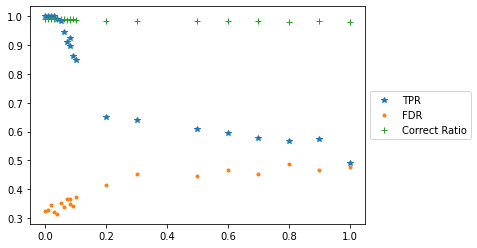

In [7]:
plt.plot(a,TPR,'*',label='TPR')
plt.plot(a,FDR,'.',label='FDR')
plt.plot(a,correct_ratio,'+',label='Correct Ratio');
legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
#plt.legend(frameon=False)


In [15]:
print('TPR=',TPR)
print('FDR=',FDR)
print('correct_ratio=',correct_ratio)

TPR= [1.         0.82222222 0.76666667 0.82222222 0.71111111 0.62222222
 0.65555556 0.57777778 0.68888889]
FDR= [0.05263158 0.06329114 0.02816901 0.         0.01538462 0.05084746
 0.0483871  0.         0.03125   ]
correct_ratio= [0.98333333 0.93       0.92333333 0.94666667 0.91       0.87666667
 0.88666667 0.87333333 0.9       ]
